<a href="https://colab.research.google.com/github/ecthompsoncodes/neural-network-sentiment-analysis/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot



device = "cuda" if torch.cuda.is_available() else "cpu"
device

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-r_osq3pw
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-r_osq3pw
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4973 sha256=8339c258fde181bf044ba8e6d49c9b74960ee4dad778fdb69317aa5752a2e9b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-eseubq__/wheels/97/11/17/d09e895f9883bd50923ce86b249a31790356a1b88b280983d8
Successfully built torchviz


'cpu'

In [3]:
# upload the data
train_orig = pd.read_csv("train.csv", delimiter = '\t')
train_gl = pd.read_csv("trainx.csv")

test_orig = pd.read_csv("test.csv",  delimiter = '\t')
test_gl = pd.read_csv("testx.csv")

valid_orig = pd.read_csv("validation.csv",  delimiter = '\t')
valid_gl = pd.read_csv("validationx.csv")

In [4]:
valid_gl.isna()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1097,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1098,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1099,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
# turn our classes into "category" type for our analysis

train_gl['FiveClass'] = train_orig['FiveClass'].astype('category')
test_gl['FiveClass'] = test_orig['FiveClass'].astype('category')
valid_gl['FiveClass'] = valid_orig['FiveClass'].astype('category')

train_gl['FiveClass'].replace(['negative', 'neutral', 'positive', 'very negative', 'very positive'],
                        [0, 1, 2, 3, 4], inplace=True)
test_gl['FiveClass'].replace(['negative', 'neutral', 'positive', 'very negative', 'very positive'],
                        [0, 1, 2, 3, 4], inplace=True)
valid_gl['FiveClass'].replace(['negative', 'neutral', 'positive', 'very negative', 'very positive'],
                        [0, 1, 2, 3, 4], inplace=True)

In [6]:
# split features and labels

dummy_cols = ["FiveClass_negative", "FiveClass_neutral", "FiveClass_positive", "FiveClass_very negative", "FiveClass_very positive"]
X_train = train_gl.drop(columns= "FiveClass")
y_train = train_gl['FiveClass']

X_valid = valid_gl.drop(columns= "FiveClass")
y_valid = valid_gl['FiveClass']

X_test = test_gl.drop(columns= "FiveClass")
y_test = test_gl['FiveClass']


In [7]:
# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_valid.to_numpy(dtype=np.float32)
y_valid_np = y_valid.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)


In [32]:
# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
# define Neural Network Architecture

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 1000
num_classes = y_train_np.max()+1  # number of output classes
dropout_prob = 0.5

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam since NLP


In [34]:
# Make a diagram of neural network

sample_input = torch.randn(1, input_size)
output = model(sample_input)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render("model_diagram")

'model_diagram.png'

In [35]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [36]:
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")



Epoch 1/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 264.20it/s]


Average Training Loss: 1.5121


Epoch 1/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 725.80it/s]


Validation Accuracy: 0.3442


Epoch 2/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 254.36it/s]


Average Training Loss: 1.4147


Epoch 2/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 617.95it/s]


Validation Accuracy: 0.4087


Epoch 3/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 252.24it/s]


Average Training Loss: 1.3872


Epoch 3/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 599.79it/s]


Validation Accuracy: 0.3951


Epoch 4/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 228.51it/s]


Average Training Loss: 1.3708


Epoch 4/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 574.02it/s]


Validation Accuracy: 0.3842


Epoch 5/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 227.91it/s]


Average Training Loss: 1.3626


Epoch 5/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 646.43it/s]


Validation Accuracy: 0.3842


Epoch 6/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 247.52it/s]


Average Training Loss: 1.3533


Epoch 6/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 527.27it/s]


Validation Accuracy: 0.3824


Epoch 7/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 190.67it/s]


Average Training Loss: 1.3448


Epoch 7/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 474.23it/s]


Validation Accuracy: 0.4005


Epoch 8/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 179.98it/s]


Average Training Loss: 1.3453


Epoch 8/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 488.61it/s]


Validation Accuracy: 0.3987


Epoch 9/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 198.26it/s]


Average Training Loss: 1.3377


Epoch 9/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 527.59it/s]


Validation Accuracy: 0.3996


Epoch 10/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 175.70it/s]


Average Training Loss: 1.3307


Epoch 10/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 436.89it/s]


Validation Accuracy: 0.3987


Epoch 11/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 164.68it/s]


Average Training Loss: 1.3212


Epoch 11/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 462.08it/s]


Validation Accuracy: 0.4051


Epoch 12/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 168.31it/s]


Average Training Loss: 1.3161


Epoch 12/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 503.93it/s]


Validation Accuracy: 0.4005


Epoch 13/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 231.46it/s]


Average Training Loss: 1.3151


Epoch 13/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 580.50it/s]


Validation Accuracy: 0.3960


Epoch 14/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 244.54it/s]


Average Training Loss: 1.3095


Epoch 14/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 744.27it/s]


Validation Accuracy: 0.3924


Epoch 15/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 245.48it/s]


Average Training Loss: 1.3050


Epoch 15/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 613.86it/s]


Validation Accuracy: 0.3887


Epoch 16/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 252.12it/s]


Average Training Loss: 1.2986


Epoch 16/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 745.71it/s]


Validation Accuracy: 0.4015


Epoch 17/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 245.87it/s]


Average Training Loss: 1.2931


Epoch 17/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 689.62it/s]


Validation Accuracy: 0.4015


Epoch 18/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 253.40it/s]


Average Training Loss: 1.2833


Epoch 18/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 762.02it/s]


Validation Accuracy: 0.3996


Epoch 19/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 233.17it/s]


Average Training Loss: 1.2804


Epoch 19/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 689.32it/s]


Validation Accuracy: 0.3915


Epoch 20/20 - Training: 100%|██████████| 134/134 [00:00<00:00, 244.89it/s]


Average Training Loss: 1.2776


Epoch 20/20 - Validation: 100%|██████████| 18/18 [00:00<00:00, 704.37it/s]

Validation Accuracy: 0.4033


In [18]:
# Define a grid of hyperparameters to search
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_sizes = [128, 256, 512]
dropout_probs = [0.0, 0.1, 0.2, 0.5, 0.7]
num_epochs = 20
batch_size = 64

best_val_accuracy = 0.0
best_hyperparameters = None

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for dropout_prob in dropout_probs:
            # Create and train the model with the current set of hyperparameters
            model = NeuralNet(input_size, hidden_size, num_classes, dropout_prob)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            # Training and validation loop
            for epoch in range(num_epochs):
              # Training phase
              model.train()
              train_loss = 0.0
              train_steps = 0
              for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
                  inputs, labels = inputs.to(device), labels.to(device)
                  outputs = model(inputs)
                  # loss = criterion(outputs, labels.float())
                  loss = criterion(outputs, labels)

                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

                  train_loss += loss.item()
                  train_steps += 1

              # Print average training loss per batch
              print(f"Average Training Loss: {train_loss / train_steps:.4f}")

              # Validation phase
              model.eval()
              val_labels = []
              val_preds = []
              with torch.no_grad():
                  for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                      inputs, labels = inputs.to(device), labels.to(device)
                      outputs = model(inputs)

                      predicted = torch.argmax(outputs.data, 1)
                      val_labels.extend(labels.cpu().numpy())
                      val_preds.extend(predicted.cpu().numpy())


            # Calculate validation accuracy
            val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

            # Check if this set of hyperparameters resulted in better performance
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparameters = {
                    'lr': lr,
                    'hidden_size': hidden_size,
                    'dropout_prob': dropout_prob,
                }

print("Best Hyperparameters:")
print(best_hyperparameters)
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 502.35it/s]


Average Training Loss: 1.5661


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 722.03it/s]


Average Training Loss: 1.5269


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 742.13it/s]


Average Training Loss: 1.4906


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 360.18it/s]


Average Training Loss: 1.4601


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 460.43it/s]


Average Training Loss: 1.4359


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 312.03it/s]


Average Training Loss: 1.4174


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 699.94it/s]


Average Training Loss: 1.4027


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 707.61it/s]


Average Training Loss: 1.3914


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 738.15it/s]


Average Training Loss: 1.3838


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 734.10it/s]


Average Training Loss: 1.3769


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 742.75it/s]


Average Training Loss: 1.3712


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 741.51it/s]


Average Training Loss: 1.3665


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 580.78it/s]


Average Training Loss: 1.3627


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 554.94it/s]


Average Training Loss: 1.3590


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.32it/s]


Average Training Loss: 1.3555


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 708.87it/s]


Average Training Loss: 1.3520


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 712.55it/s]


Average Training Loss: 1.3499


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 727.38it/s]


Average Training Loss: 1.3475


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 739.62it/s]


Average Training Loss: 1.3441


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 732.35it/s]


Average Training Loss: 1.3412


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 707.95it/s]


Average Training Loss: 1.5618


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 507.11it/s]


Average Training Loss: 1.5309


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 506.59it/s]


Average Training Loss: 1.4990


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 662.77it/s]


Average Training Loss: 1.4690


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 682.42it/s]


Average Training Loss: 1.4452


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 685.99it/s]


Average Training Loss: 1.4248


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 699.54it/s]


Average Training Loss: 1.4103


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 684.84it/s]


Average Training Loss: 1.4003


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 684.18it/s]


Average Training Loss: 1.3913


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 536.65it/s]


Average Training Loss: 1.3836


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.18it/s]


Average Training Loss: 1.3784


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 587.05it/s]


Average Training Loss: 1.3711


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 711.71it/s]


Average Training Loss: 1.3671


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 700.93it/s]


Average Training Loss: 1.3633


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 688.60it/s]


Average Training Loss: 1.3601


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 682.74it/s]


Average Training Loss: 1.3582


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 669.13it/s]


Average Training Loss: 1.3537


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 592.74it/s]


Average Training Loss: 1.3519


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 489.28it/s]


Average Training Loss: 1.3470


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 540.82it/s]


Average Training Loss: 1.3440


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 686.26it/s]


Average Training Loss: 1.5659


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 671.67it/s]


Average Training Loss: 1.5345


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 663.51it/s]


Average Training Loss: 1.5040


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 680.73it/s]


Average Training Loss: 1.4765


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 671.55it/s]


Average Training Loss: 1.4515


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 598.18it/s]


Average Training Loss: 1.4345


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.07it/s]


Average Training Loss: 1.4190


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 516.99it/s]


Average Training Loss: 1.4078


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 687.26it/s]


Average Training Loss: 1.3979


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 705.67it/s]


Average Training Loss: 1.3908


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 704.41it/s]


Average Training Loss: 1.3836


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 695.95it/s]


Average Training Loss: 1.3795


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 680.78it/s]


Average Training Loss: 1.3751


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 687.85it/s]


Average Training Loss: 1.3705


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 422.34it/s]


Average Training Loss: 1.3682


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.78it/s]


Average Training Loss: 1.3642


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 708.88it/s]


Average Training Loss: 1.3606


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 705.35it/s]


Average Training Loss: 1.3595


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 703.40it/s]


Average Training Loss: 1.3538


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 693.29it/s]


Average Training Loss: 1.3534


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 693.18it/s]


Average Training Loss: 1.5705


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 702.12it/s]


Average Training Loss: 1.5447


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 516.12it/s]


Average Training Loss: 1.5198


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 520.43it/s]


Average Training Loss: 1.4996


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 617.47it/s]


Average Training Loss: 1.4779


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 677.80it/s]


Average Training Loss: 1.4618


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 688.45it/s]


Average Training Loss: 1.4455


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 689.44it/s]


Average Training Loss: 1.4320


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 692.58it/s]


Average Training Loss: 1.4206


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 693.49it/s]


Average Training Loss: 1.4130


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 548.63it/s]


Average Training Loss: 1.4049


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 497.88it/s]


Average Training Loss: 1.3979


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 584.83it/s]


Average Training Loss: 1.3951


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 683.72it/s]


Average Training Loss: 1.3910


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 655.05it/s]


Average Training Loss: 1.3851


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 657.20it/s]


Average Training Loss: 1.3791


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 672.96it/s]


Average Training Loss: 1.3763


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 659.56it/s]


Average Training Loss: 1.3741


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 545.31it/s]


Average Training Loss: 1.3720


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 484.48it/s]


Average Training Loss: 1.3699


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 559.38it/s]


Average Training Loss: 1.5800


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 627.65it/s]


Average Training Loss: 1.5541


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 647.21it/s]


Average Training Loss: 1.5357


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 627.56it/s]


Average Training Loss: 1.5191


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 661.29it/s]


Average Training Loss: 1.5026


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 627.07it/s]


Average Training Loss: 1.4879


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 471.30it/s]


Average Training Loss: 1.4710


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 478.24it/s]


Average Training Loss: 1.4623


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 642.99it/s]


Average Training Loss: 1.4532


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 684.19it/s]


Average Training Loss: 1.4427


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 681.41it/s]


Average Training Loss: 1.4363


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 694.48it/s]


Average Training Loss: 1.4290


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 698.42it/s]


Average Training Loss: 1.4220


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 703.82it/s]


Average Training Loss: 1.4154


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 546.76it/s]


Average Training Loss: 1.4125


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 514.76it/s]


Average Training Loss: 1.4061


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 595.28it/s]


Average Training Loss: 1.4061


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 696.40it/s]


Average Training Loss: 1.3978


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 692.56it/s]


Average Training Loss: 1.3957


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 702.60it/s]


Average Training Loss: 1.3943


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 688.98it/s]


Average Training Loss: 1.5549


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 695.27it/s]


Average Training Loss: 1.5079


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 612.74it/s]


Average Training Loss: 1.4638


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 509.37it/s]


Average Training Loss: 1.4324


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 526.57it/s]


Average Training Loss: 1.4093


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 701.95it/s]


Average Training Loss: 1.3939


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 692.78it/s]


Average Training Loss: 1.3818


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 697.21it/s]


Average Training Loss: 1.3738


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 694.97it/s]


Average Training Loss: 1.3670


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 689.72it/s]


Average Training Loss: 1.3607


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 707.26it/s]


Average Training Loss: 1.3560


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 514.16it/s]


Average Training Loss: 1.3510


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 385.39it/s]


Average Training Loss: 1.3466


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 689.33it/s]


Average Training Loss: 1.3433


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 666.04it/s]


Average Training Loss: 1.3407


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 682.41it/s]


Average Training Loss: 1.3375


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 685.89it/s]


Average Training Loss: 1.3337


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 704.29it/s]


Average Training Loss: 1.3319


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 701.28it/s]


Average Training Loss: 1.3294


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 512.87it/s]


Average Training Loss: 1.3268


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 448.98it/s]


Average Training Loss: 1.5566


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 593.54it/s]


Average Training Loss: 1.5120


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 619.82it/s]


Average Training Loss: 1.4676


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 589.12it/s]


Average Training Loss: 1.4373


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 602.96it/s]


Average Training Loss: 1.4128


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 621.59it/s]


Average Training Loss: 1.3993


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 551.51it/s]


Average Training Loss: 1.3866


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 457.79it/s]


Average Training Loss: 1.3772


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 521.01it/s]


Average Training Loss: 1.3703


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 659.06it/s]


Average Training Loss: 1.3639


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 643.58it/s]


Average Training Loss: 1.3604


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 644.96it/s]


Average Training Loss: 1.3556


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 649.92it/s]


Average Training Loss: 1.3508


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 648.46it/s]


Average Training Loss: 1.3453


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 528.51it/s]


Average Training Loss: 1.3439


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 475.70it/s]


Average Training Loss: 1.3393


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.90it/s]


Average Training Loss: 1.3375


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 634.69it/s]


Average Training Loss: 1.3354


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 645.44it/s]


Average Training Loss: 1.3321


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 635.85it/s]


Average Training Loss: 1.3297


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 662.55it/s]


Average Training Loss: 1.5561


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 633.68it/s]


Average Training Loss: 1.5067


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 449.96it/s]


Average Training Loss: 1.4679


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 353.50it/s]


Average Training Loss: 1.4392


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 630.65it/s]


Average Training Loss: 1.4171


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 627.13it/s]


Average Training Loss: 1.4021


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 631.46it/s]


Average Training Loss: 1.3925


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 641.72it/s]


Average Training Loss: 1.3825


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 631.18it/s]


Average Training Loss: 1.3757


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 505.41it/s]


Average Training Loss: 1.3703


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 485.35it/s]


Average Training Loss: 1.3647


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 558.14it/s]


Average Training Loss: 1.3597


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 654.23it/s]


Average Training Loss: 1.3577


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 613.68it/s]


Average Training Loss: 1.3549


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 607.85it/s]


Average Training Loss: 1.3487


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 648.31it/s]


Average Training Loss: 1.3450


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 650.84it/s]


Average Training Loss: 1.3438


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 479.98it/s]


Average Training Loss: 1.3413


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 466.25it/s]


Average Training Loss: 1.3374


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 622.53it/s]


Average Training Loss: 1.3347


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 635.84it/s]


Average Training Loss: 1.5647


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 644.63it/s]


Average Training Loss: 1.5332


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 638.21it/s]


Average Training Loss: 1.5011


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 654.66it/s]


Average Training Loss: 1.4720


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 596.86it/s]


Average Training Loss: 1.4528


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 478.77it/s]


Average Training Loss: 1.4350


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 493.80it/s]


Average Training Loss: 1.4202


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 638.18it/s]


Average Training Loss: 1.4074


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 635.21it/s]


Average Training Loss: 1.3986


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 639.66it/s]


Average Training Loss: 1.3897


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 635.18it/s]


Average Training Loss: 1.3853


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 656.03it/s]


Average Training Loss: 1.3798


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 572.84it/s]


Average Training Loss: 1.3757


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.50it/s]


Average Training Loss: 1.3716


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 500.57it/s]


Average Training Loss: 1.3660


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 639.60it/s]


Average Training Loss: 1.3634


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 631.98it/s]


Average Training Loss: 1.3609


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 638.67it/s]


Average Training Loss: 1.3563


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 623.61it/s]


Average Training Loss: 1.3531


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 630.65it/s]


Average Training Loss: 1.3540


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.30it/s]


Average Training Loss: 1.5694


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 452.91it/s]


Average Training Loss: 1.5441


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.79it/s]


Average Training Loss: 1.5201


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 623.89it/s]


Average Training Loss: 1.4979


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 627.57it/s]


Average Training Loss: 1.4815


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 615.59it/s]


Average Training Loss: 1.4614


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 597.97it/s]


Average Training Loss: 1.4476


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.70it/s]


Average Training Loss: 1.4364


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 429.59it/s]


Average Training Loss: 1.4217


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 509.21it/s]


Average Training Loss: 1.4176


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 623.90it/s]


Average Training Loss: 1.4096


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 621.68it/s]


Average Training Loss: 1.4013


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 632.11it/s]


Average Training Loss: 1.3946


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 629.75it/s]


Average Training Loss: 1.3913


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 636.40it/s]


Average Training Loss: 1.3885


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 513.11it/s]


Average Training Loss: 1.3836


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 495.04it/s]


Average Training Loss: 1.3829


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.72it/s]


Average Training Loss: 1.3757


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 631.17it/s]


Average Training Loss: 1.3735


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 643.19it/s]


Average Training Loss: 1.3701


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 626.62it/s]


Average Training Loss: 1.5453


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 634.21it/s]


Average Training Loss: 1.4793


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 631.32it/s]


Average Training Loss: 1.4324


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 474.24it/s]


Average Training Loss: 1.4034


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 470.77it/s]


Average Training Loss: 1.3838


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 582.82it/s]


Average Training Loss: 1.3722


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 615.57it/s]


Average Training Loss: 1.3639


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 589.58it/s]


Average Training Loss: 1.3557


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 612.34it/s]


Average Training Loss: 1.3502


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 629.96it/s]


Average Training Loss: 1.3458


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 544.30it/s]


Average Training Loss: 1.3399


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 450.19it/s]


Average Training Loss: 1.3356


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 511.89it/s]


Average Training Loss: 1.3309


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 633.82it/s]


Average Training Loss: 1.3272


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 629.35it/s]


Average Training Loss: 1.3233


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 619.65it/s]


Average Training Loss: 1.3207


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 603.80it/s]


Average Training Loss: 1.3183


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 627.19it/s]


Average Training Loss: 1.3156


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 481.49it/s]


Average Training Loss: 1.3110


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 459.36it/s]


Average Training Loss: 1.3098


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 546.04it/s]


Average Training Loss: 1.5444


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 569.60it/s]


Average Training Loss: 1.4836


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.46it/s]


Average Training Loss: 1.4378


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.26it/s]


Average Training Loss: 1.4079


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.39it/s]


Average Training Loss: 1.3894


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 460.06it/s]


Average Training Loss: 1.3770


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 417.41it/s]


Average Training Loss: 1.3685


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 534.91it/s]


Average Training Loss: 1.3603


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.60it/s]


Average Training Loss: 1.3538


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 550.29it/s]


Average Training Loss: 1.3496


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 563.95it/s]


Average Training Loss: 1.3454


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 541.28it/s]


Average Training Loss: 1.3395


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 444.47it/s]


Average Training Loss: 1.3364


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 425.87it/s]


Average Training Loss: 1.3340


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.96it/s]


Average Training Loss: 1.3301


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 565.16it/s]


Average Training Loss: 1.3256


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 562.56it/s]


Average Training Loss: 1.3220


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 554.28it/s]


Average Training Loss: 1.3196


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 579.95it/s]


Average Training Loss: 1.3166


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 437.99it/s]


Average Training Loss: 1.3134


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 430.43it/s]


Average Training Loss: 1.5469


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 591.11it/s]


Average Training Loss: 1.4879


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 587.10it/s]


Average Training Loss: 1.4408


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 583.39it/s]


Average Training Loss: 1.4126


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 577.67it/s]


Average Training Loss: 1.3949


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 582.43it/s]


Average Training Loss: 1.3821


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 458.84it/s]


Average Training Loss: 1.3712


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 430.51it/s]


Average Training Loss: 1.3639


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 544.23it/s]


Average Training Loss: 1.3583


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 585.55it/s]


Average Training Loss: 1.3518


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 586.35it/s]


Average Training Loss: 1.3486


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 593.61it/s]


Average Training Loss: 1.3423


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 556.18it/s]


Average Training Loss: 1.3383


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 439.05it/s]


Average Training Loss: 1.3369


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 428.93it/s]


Average Training Loss: 1.3306


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 529.62it/s]


Average Training Loss: 1.3290


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 596.50it/s]


Average Training Loss: 1.3255


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 595.20it/s]


Average Training Loss: 1.3225


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 580.47it/s]


Average Training Loss: 1.3182


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 588.11it/s]


Average Training Loss: 1.3153


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 484.22it/s]


Average Training Loss: 1.5533


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 432.78it/s]


Average Training Loss: 1.5114


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 486.61it/s]


Average Training Loss: 1.4721


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 575.96it/s]


Average Training Loss: 1.4447


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 574.72it/s]


Average Training Loss: 1.4206


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.90it/s]


Average Training Loss: 1.4064


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 568.76it/s]


Average Training Loss: 1.3934


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 475.07it/s]


Average Training Loss: 1.3846


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 424.72it/s]


Average Training Loss: 1.3778


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 503.89it/s]


Average Training Loss: 1.3684


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 571.35it/s]


Average Training Loss: 1.3667


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 567.94it/s]


Average Training Loss: 1.3610


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 575.76it/s]


Average Training Loss: 1.3588


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 554.41it/s]


Average Training Loss: 1.3553


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 449.47it/s]


Average Training Loss: 1.3515


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 438.65it/s]


Average Training Loss: 1.3472


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 530.48it/s]


Average Training Loss: 1.3443


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 569.34it/s]


Average Training Loss: 1.3403


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 567.18it/s]


Average Training Loss: 1.3387


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 571.95it/s]


Average Training Loss: 1.3357


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 555.81it/s]


Average Training Loss: 1.5635


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 432.59it/s]


Average Training Loss: 1.5301


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 412.40it/s]


Average Training Loss: 1.4994


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 522.82it/s]


Average Training Loss: 1.4752


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 555.40it/s]


Average Training Loss: 1.4534


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.02it/s]


Average Training Loss: 1.4323


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.85it/s]


Average Training Loss: 1.4200


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 559.38it/s]


Average Training Loss: 1.4091


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 439.13it/s]


Average Training Loss: 1.3989


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 411.39it/s]


Average Training Loss: 1.3961


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 563.50it/s]


Average Training Loss: 1.3887


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.52it/s]


Average Training Loss: 1.3829


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.48it/s]


Average Training Loss: 1.3777


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 566.00it/s]


Average Training Loss: 1.3760


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.75it/s]


Average Training Loss: 1.3709


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 426.01it/s]


Average Training Loss: 1.3668


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 422.88it/s]


Average Training Loss: 1.3672


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.02it/s]


Average Training Loss: 1.3598


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 557.12it/s]


Average Training Loss: 1.3568


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 556.65it/s]


Average Training Loss: 1.3552


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 729.83it/s]


Average Training Loss: 1.4750


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 713.60it/s]


Average Training Loss: 1.3880


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.00it/s]


Average Training Loss: 1.3638


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 523.67it/s]


Average Training Loss: 1.3505


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.22it/s]


Average Training Loss: 1.3410


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 714.67it/s]


Average Training Loss: 1.3312


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 699.96it/s]


Average Training Loss: 1.3209


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 708.21it/s]


Average Training Loss: 1.3119


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 710.25it/s]


Average Training Loss: 1.3024


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 701.40it/s]


Average Training Loss: 1.2961


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 714.81it/s]


Average Training Loss: 1.2852


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 540.33it/s]


Average Training Loss: 1.2795


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 535.91it/s]


Average Training Loss: 1.2693


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 574.53it/s]


Average Training Loss: 1.2574


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 710.47it/s]


Average Training Loss: 1.2480


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 715.97it/s]


Average Training Loss: 1.2385


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 713.95it/s]


Average Training Loss: 1.2261


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 695.65it/s]


Average Training Loss: 1.2200


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 695.98it/s]


Average Training Loss: 1.2120


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 679.48it/s]


Average Training Loss: 1.2013


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.96it/s]


Average Training Loss: 1.4820


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 509.91it/s]


Average Training Loss: 1.3948


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 635.30it/s]


Average Training Loss: 1.3689


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 673.88it/s]


Average Training Loss: 1.3578


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 667.25it/s]


Average Training Loss: 1.3463


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 641.48it/s]


Average Training Loss: 1.3387


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 650.10it/s]


Average Training Loss: 1.3320


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 669.87it/s]


Average Training Loss: 1.3194


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.12it/s]


Average Training Loss: 1.3180


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.41it/s]


Average Training Loss: 1.3107


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 605.89it/s]


Average Training Loss: 1.3060


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 661.44it/s]


Average Training Loss: 1.2906


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 672.68it/s]


Average Training Loss: 1.2905


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 677.18it/s]


Average Training Loss: 1.2811


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 670.00it/s]


Average Training Loss: 1.2699


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 665.00it/s]


Average Training Loss: 1.2651


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 521.32it/s]


Average Training Loss: 1.2604


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.57it/s]


Average Training Loss: 1.2515


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 562.38it/s]


Average Training Loss: 1.2436


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 659.95it/s]


Average Training Loss: 1.2367


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 643.81it/s]


Average Training Loss: 1.4914


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 617.51it/s]


Average Training Loss: 1.3977


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 651.41it/s]


Average Training Loss: 1.3751


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 645.29it/s]


Average Training Loss: 1.3656


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 486.95it/s]


Average Training Loss: 1.3528


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 458.57it/s]


Average Training Loss: 1.3440


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 556.12it/s]


Average Training Loss: 1.3399


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 639.02it/s]


Average Training Loss: 1.3311


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 641.35it/s]


Average Training Loss: 1.3250


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 629.10it/s]


Average Training Loss: 1.3175


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 625.79it/s]


Average Training Loss: 1.3128


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 603.89it/s]


Average Training Loss: 1.3099


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 446.79it/s]


Average Training Loss: 1.3053


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 460.37it/s]


Average Training Loss: 1.2932


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 640.01it/s]


Average Training Loss: 1.2889


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 652.02it/s]


Average Training Loss: 1.2840


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 602.92it/s]


Average Training Loss: 1.2827


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 595.22it/s]


Average Training Loss: 1.2721


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 610.39it/s]


Average Training Loss: 1.2707


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 471.61it/s]


Average Training Loss: 1.2620


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 444.85it/s]


Average Training Loss: 1.5071


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.45it/s]


Average Training Loss: 1.4205


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 629.13it/s]


Average Training Loss: 1.3978


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 638.70it/s]


Average Training Loss: 1.3882


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 621.08it/s]


Average Training Loss: 1.3783


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 611.26it/s]


Average Training Loss: 1.3709


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 629.42it/s]


Average Training Loss: 1.3638


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 461.07it/s]


Average Training Loss: 1.3608


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 460.61it/s]


Average Training Loss: 1.3509


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 652.86it/s]


Average Training Loss: 1.3547


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 644.60it/s]


Average Training Loss: 1.3447


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 649.82it/s]


Average Training Loss: 1.3450


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 660.02it/s]


Average Training Loss: 1.3406


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 634.72it/s]


Average Training Loss: 1.3354


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 616.47it/s]


Average Training Loss: 1.3342


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 500.94it/s]


Average Training Loss: 1.3331


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 486.51it/s]


Average Training Loss: 1.3275


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 625.33it/s]


Average Training Loss: 1.3223


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 641.91it/s]


Average Training Loss: 1.3256


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 655.56it/s]


Average Training Loss: 1.3158


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 665.79it/s]


Average Training Loss: 1.5351


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 662.16it/s]


Average Training Loss: 1.4615


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 643.93it/s]


Average Training Loss: 1.4317


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.32it/s]


Average Training Loss: 1.4191


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 495.75it/s]


Average Training Loss: 1.4066


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 584.63it/s]


Average Training Loss: 1.3976


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 649.06it/s]


Average Training Loss: 1.3948


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 644.32it/s]


Average Training Loss: 1.3918


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 641.58it/s]


Average Training Loss: 1.3873


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 642.59it/s]


Average Training Loss: 1.3798


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 658.17it/s]


Average Training Loss: 1.3814


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 497.63it/s]


Average Training Loss: 1.3814


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 498.09it/s]


Average Training Loss: 1.3759


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 586.52it/s]


Average Training Loss: 1.3735


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 651.56it/s]


Average Training Loss: 1.3754


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 646.27it/s]


Average Training Loss: 1.3696


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 656.29it/s]


Average Training Loss: 1.3662


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 647.19it/s]


Average Training Loss: 1.3693


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 653.26it/s]


Average Training Loss: 1.3642


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 508.82it/s]


Average Training Loss: 1.3608


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 514.00it/s]


Average Training Loss: 1.4639


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 540.05it/s]


Average Training Loss: 1.3837


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 623.43it/s]


Average Training Loss: 1.3611


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 619.22it/s]


Average Training Loss: 1.3452


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 626.49it/s]


Average Training Loss: 1.3338


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 625.94it/s]


Average Training Loss: 1.3267


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 632.05it/s]


Average Training Loss: 1.3131


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 484.13it/s]


Average Training Loss: 1.3045


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 470.40it/s]


Average Training Loss: 1.2951


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.68it/s]


Average Training Loss: 1.2836


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 632.03it/s]


Average Training Loss: 1.2739


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 645.73it/s]


Average Training Loss: 1.2614


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 642.12it/s]


Average Training Loss: 1.2456


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 648.81it/s]


Average Training Loss: 1.2359


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 651.53it/s]


Average Training Loss: 1.2233


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.46it/s]


Average Training Loss: 1.2087


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 476.02it/s]


Average Training Loss: 1.1970


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 586.28it/s]


Average Training Loss: 1.1829


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 631.32it/s]


Average Training Loss: 1.1684


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 612.44it/s]


Average Training Loss: 1.1538


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 594.33it/s]


Average Training Loss: 1.4699


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 568.70it/s]


Average Training Loss: 1.3850


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 534.24it/s]


Average Training Loss: 1.3683


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 442.03it/s]


Average Training Loss: 1.3506


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 494.38it/s]


Average Training Loss: 1.3425


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 595.74it/s]


Average Training Loss: 1.3334


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 602.33it/s]


Average Training Loss: 1.3253


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 601.38it/s]


Average Training Loss: 1.3125


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 619.15it/s]


Average Training Loss: 1.3063


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 625.80it/s]


Average Training Loss: 1.3002


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 463.51it/s]


Average Training Loss: 1.2854


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 455.60it/s]


Average Training Loss: 1.2762


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 567.68it/s]


Average Training Loss: 1.2672


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 606.53it/s]


Average Training Loss: 1.2605


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 625.90it/s]


Average Training Loss: 1.2456


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 613.78it/s]


Average Training Loss: 1.2345


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 618.18it/s]


Average Training Loss: 1.2255


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 541.21it/s]


Average Training Loss: 1.2176


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 467.55it/s]


Average Training Loss: 1.2087


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.62it/s]


Average Training Loss: 1.1930


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 637.65it/s]


Average Training Loss: 1.4748


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 610.97it/s]


Average Training Loss: 1.3907


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 607.28it/s]


Average Training Loss: 1.3723


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 623.53it/s]


Average Training Loss: 1.3593


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 601.55it/s]


Average Training Loss: 1.3462


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 491.87it/s]


Average Training Loss: 1.3374


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 448.54it/s]


Average Training Loss: 1.3299


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 528.77it/s]


Average Training Loss: 1.3226


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 607.61it/s]


Average Training Loss: 1.3139


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 601.55it/s]


Average Training Loss: 1.3029


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 584.17it/s]


Average Training Loss: 1.2966


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 590.03it/s]


Average Training Loss: 1.2897


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 540.14it/s]


Average Training Loss: 1.2793


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 447.47it/s]


Average Training Loss: 1.2699


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 452.04it/s]


Average Training Loss: 1.2659


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 604.20it/s]


Average Training Loss: 1.2577


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 605.20it/s]


Average Training Loss: 1.2410


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 602.64it/s]


Average Training Loss: 1.2367


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 625.31it/s]


Average Training Loss: 1.2275


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 611.43it/s]


Average Training Loss: 1.2170


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 471.63it/s]


Average Training Loss: 1.4989


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 452.85it/s]


Average Training Loss: 1.4166


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 547.95it/s]


Average Training Loss: 1.3964


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 581.24it/s]


Average Training Loss: 1.3823


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 598.88it/s]


Average Training Loss: 1.3739


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 586.43it/s]


Average Training Loss: 1.3583


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 588.79it/s]


Average Training Loss: 1.3582


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 495.80it/s]


Average Training Loss: 1.3553


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 453.14it/s]


Average Training Loss: 1.3507


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 503.11it/s]


Average Training Loss: 1.3412


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 588.80it/s]


Average Training Loss: 1.3401


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 588.69it/s]


Average Training Loss: 1.3350


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 586.19it/s]


Average Training Loss: 1.3269


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 590.13it/s]


Average Training Loss: 1.3253


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 572.18it/s]


Average Training Loss: 1.3250


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 445.59it/s]


Average Training Loss: 1.3158


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 444.60it/s]


Average Training Loss: 1.3144


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 594.52it/s]


Average Training Loss: 1.3043


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 581.98it/s]


Average Training Loss: 1.3065


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 581.57it/s]


Average Training Loss: 1.3073


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 626.48it/s]


Average Training Loss: 1.5297


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 593.09it/s]


Average Training Loss: 1.4466


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 454.15it/s]


Average Training Loss: 1.4240


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 423.94it/s]


Average Training Loss: 1.4076


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 567.37it/s]


Average Training Loss: 1.3988


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 576.91it/s]


Average Training Loss: 1.3938


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 583.85it/s]


Average Training Loss: 1.3876


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 580.91it/s]


Average Training Loss: 1.3867


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 589.75it/s]


Average Training Loss: 1.3784


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 474.47it/s]


Average Training Loss: 1.3728


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 450.65it/s]


Average Training Loss: 1.3648


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 507.59it/s]


Average Training Loss: 1.3703


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 577.11it/s]


Average Training Loss: 1.3661


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 589.18it/s]


Average Training Loss: 1.3616


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 574.37it/s]


Average Training Loss: 1.3594


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 591.19it/s]


Average Training Loss: 1.3558


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 524.03it/s]


Average Training Loss: 1.3555


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 444.05it/s]


Average Training Loss: 1.3545


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 451.58it/s]


Average Training Loss: 1.3484


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 587.87it/s]


Average Training Loss: 1.3510


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 596.82it/s]


Average Training Loss: 1.4520


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 569.76it/s]


Average Training Loss: 1.3804


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 565.16it/s]


Average Training Loss: 1.3604


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 538.39it/s]


Average Training Loss: 1.3440


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 415.50it/s]


Average Training Loss: 1.3306


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 427.09it/s]


Average Training Loss: 1.3179


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 539.75it/s]


Average Training Loss: 1.3045


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.14it/s]


Average Training Loss: 1.2972


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.09it/s]


Average Training Loss: 1.2772


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 558.64it/s]


Average Training Loss: 1.2629


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 517.39it/s]


Average Training Loss: 1.2504


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 414.34it/s]


Average Training Loss: 1.2313


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 456.18it/s]


Average Training Loss: 1.2198


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 554.42it/s]


Average Training Loss: 1.2007


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.55it/s]


Average Training Loss: 1.1842


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 543.87it/s]


Average Training Loss: 1.1665


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.61it/s]


Average Training Loss: 1.1495


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 493.42it/s]


Average Training Loss: 1.1321


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 409.81it/s]


Average Training Loss: 1.1144


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 471.91it/s]


Average Training Loss: 1.0945


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 573.31it/s]


Average Training Loss: 1.4581


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 538.18it/s]


Average Training Loss: 1.3842


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 530.65it/s]


Average Training Loss: 1.3685


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 533.65it/s]


Average Training Loss: 1.3516


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 433.23it/s]


Average Training Loss: 1.3360


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 394.28it/s]


Average Training Loss: 1.3265


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.35it/s]


Average Training Loss: 1.3163


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 532.75it/s]


Average Training Loss: 1.3045


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 519.44it/s]


Average Training Loss: 1.2950


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 540.67it/s]


Average Training Loss: 1.2861


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 536.37it/s]


Average Training Loss: 1.2671


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.63it/s]


Average Training Loss: 1.2609


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 409.10it/s]


Average Training Loss: 1.2460


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 535.33it/s]


Average Training Loss: 1.2298


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 513.75it/s]


Average Training Loss: 1.2145


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 536.90it/s]


Average Training Loss: 1.2020


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 530.74it/s]


Average Training Loss: 1.1883


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 452.98it/s]


Average Training Loss: 1.1729


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 379.76it/s]


Average Training Loss: 1.1603


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 453.74it/s]


Average Training Loss: 1.1406


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 562.61it/s]


Average Training Loss: 1.4669


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 526.75it/s]


Average Training Loss: 1.3860


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 533.59it/s]


Average Training Loss: 1.3678


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 517.55it/s]


Average Training Loss: 1.3570


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 398.24it/s]


Average Training Loss: 1.3451


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 392.08it/s]


Average Training Loss: 1.3340


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 403.84it/s]


Average Training Loss: 1.3267


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 502.12it/s]


Average Training Loss: 1.3197


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.28it/s]


Average Training Loss: 1.3066


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 474.75it/s]


Average Training Loss: 1.2954


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 341.35it/s]


Average Training Loss: 1.2843


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 361.50it/s]


Average Training Loss: 1.2779


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 414.20it/s]


Average Training Loss: 1.2639


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 493.41it/s]


Average Training Loss: 1.2442


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 519.30it/s]


Average Training Loss: 1.2414


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 491.39it/s]


Average Training Loss: 1.2310


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 376.66it/s]


Average Training Loss: 1.2178


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 385.50it/s]


Average Training Loss: 1.2077


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 516.84it/s]


Average Training Loss: 1.1875


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 528.71it/s]


Average Training Loss: 1.1826


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.62it/s]


Average Training Loss: 1.4876


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 524.13it/s]


Average Training Loss: 1.4112


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 423.64it/s]


Average Training Loss: 1.3906


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 398.14it/s]


Average Training Loss: 1.3812


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 480.04it/s]


Average Training Loss: 1.3714


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 513.98it/s]


Average Training Loss: 1.3634


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 502.88it/s]


Average Training Loss: 1.3559


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 508.79it/s]


Average Training Loss: 1.3528


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 459.65it/s]


Average Training Loss: 1.3447


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 382.31it/s]


Average Training Loss: 1.3385


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 410.63it/s]


Average Training Loss: 1.3357


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 495.78it/s]


Average Training Loss: 1.3244


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 500.63it/s]


Average Training Loss: 1.3257


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.95it/s]


Average Training Loss: 1.3166


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 503.50it/s]


Average Training Loss: 1.3147


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 373.47it/s]


Average Training Loss: 1.3068


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 400.82it/s]


Average Training Loss: 1.3031


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 515.10it/s]


Average Training Loss: 1.2942


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 499.16it/s]


Average Training Loss: 1.2877


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 494.18it/s]


Average Training Loss: 1.2857


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 537.50it/s]


Average Training Loss: 1.5209


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 397.53it/s]


Average Training Loss: 1.4401


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 363.97it/s]


Average Training Loss: 1.4113


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 442.55it/s]


Average Training Loss: 1.4031


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 472.41it/s]


Average Training Loss: 1.3959


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 467.95it/s]


Average Training Loss: 1.3859


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 457.35it/s]


Average Training Loss: 1.3844


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 381.27it/s]


Average Training Loss: 1.3841


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 364.97it/s]


Average Training Loss: 1.3785


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 473.32it/s]


Average Training Loss: 1.3729


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 465.74it/s]


Average Training Loss: 1.3682


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.10it/s]


Average Training Loss: 1.3572


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 460.68it/s]


Average Training Loss: 1.3608


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.24it/s]


Average Training Loss: 1.3629


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 332.23it/s]


Average Training Loss: 1.3518


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 421.85it/s]


Average Training Loss: 1.3500


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 397.44it/s]


Average Training Loss: 1.3473


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 445.49it/s]


Average Training Loss: 1.3478


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 386.05it/s]


Average Training Loss: 1.3407


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 354.29it/s]


Average Training Loss: 1.3463


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 588.83it/s]


Average Training Loss: 1.4520


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 622.88it/s]


Average Training Loss: 1.3959


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 624.01it/s]


Average Training Loss: 1.3842


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 602.72it/s]


Average Training Loss: 1.3708


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 618.17it/s]


Average Training Loss: 1.3591


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 610.02it/s]


Average Training Loss: 1.3570


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 460.03it/s]


Average Training Loss: 1.3580


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 427.87it/s]


Average Training Loss: 1.3473


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 604.65it/s]


Average Training Loss: 1.3476


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 604.52it/s]


Average Training Loss: 1.3391


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 595.11it/s]


Average Training Loss: 1.3366


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 605.98it/s]


Average Training Loss: 1.3433


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 593.05it/s]


Average Training Loss: 1.3380


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 538.04it/s]


Average Training Loss: 1.3333


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 471.47it/s]


Average Training Loss: 1.3260


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 499.15it/s]


Average Training Loss: 1.3263


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 603.66it/s]


Average Training Loss: 1.3240


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 592.58it/s]


Average Training Loss: 1.3207


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 582.28it/s]


Average Training Loss: 1.3243


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 605.30it/s]


Average Training Loss: 1.3239


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 625.72it/s]


Average Training Loss: 1.4626


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 455.27it/s]


Average Training Loss: 1.4065


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 446.76it/s]


Average Training Loss: 1.3950


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 542.71it/s]


Average Training Loss: 1.3948


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 595.14it/s]


Average Training Loss: 1.3848


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 588.45it/s]


Average Training Loss: 1.3812


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 583.85it/s]


Average Training Loss: 1.3740


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.85it/s]


Average Training Loss: 1.3667


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 502.88it/s]


Average Training Loss: 1.3668


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 448.07it/s]


Average Training Loss: 1.3671


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 473.88it/s]


Average Training Loss: 1.3628


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 578.76it/s]


Average Training Loss: 1.3598


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 589.96it/s]


Average Training Loss: 1.3574


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 581.75it/s]


Average Training Loss: 1.3558


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.27it/s]


Average Training Loss: 1.3563


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 547.05it/s]


Average Training Loss: 1.3556


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 449.82it/s]


Average Training Loss: 1.3553


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 439.32it/s]


Average Training Loss: 1.3552


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 595.17it/s]


Average Training Loss: 1.3528


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 589.65it/s]


Average Training Loss: 1.3506


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 639.52it/s]


Average Training Loss: 1.4799


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 588.34it/s]


Average Training Loss: 1.4282


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 569.45it/s]


Average Training Loss: 1.4192


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 438.91it/s]


Average Training Loss: 1.4134


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 419.72it/s]


Average Training Loss: 1.4047


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 544.01it/s]


Average Training Loss: 1.4020


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 569.95it/s]


Average Training Loss: 1.3943


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 578.36it/s]


Average Training Loss: 1.3987


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 583.91it/s]


Average Training Loss: 1.3938


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 581.68it/s]


Average Training Loss: 1.3928


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 468.17it/s]


Average Training Loss: 1.3903


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 425.16it/s]


Average Training Loss: 1.3834


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 503.13it/s]


Average Training Loss: 1.3861


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 572.58it/s]


Average Training Loss: 1.3811


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 583.57it/s]


Average Training Loss: 1.3824


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 581.71it/s]


Average Training Loss: 1.3851


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 583.37it/s]


Average Training Loss: 1.3824


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 506.50it/s]


Average Training Loss: 1.3735


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 451.48it/s]


Average Training Loss: 1.3801


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 472.40it/s]


Average Training Loss: 1.3781


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 635.62it/s]


Average Training Loss: 1.5284


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 583.52it/s]


Average Training Loss: 1.4889


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 572.97it/s]


Average Training Loss: 1.4701


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 556.73it/s]


Average Training Loss: 1.4695


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 579.51it/s]


Average Training Loss: 1.4646


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 442.77it/s]


Average Training Loss: 1.4616


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 424.07it/s]


Average Training Loss: 1.4519


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 527.53it/s]


Average Training Loss: 1.4554


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 569.91it/s]


Average Training Loss: 1.4549


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 513.83it/s]


Average Training Loss: 1.4593


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 554.61it/s]


Average Training Loss: 1.4566


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 572.46it/s]


Average Training Loss: 1.4498


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 438.70it/s]


Average Training Loss: 1.4568


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 404.00it/s]


Average Training Loss: 1.4453


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 552.77it/s]


Average Training Loss: 1.4524


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 562.71it/s]


Average Training Loss: 1.4487


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 563.91it/s]


Average Training Loss: 1.4523


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 547.68it/s]


Average Training Loss: 1.4462


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 532.00it/s]


Average Training Loss: 1.4523


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 377.89it/s]


Average Training Loss: 1.4423


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 421.27it/s]


Average Training Loss: 1.5765


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 530.77it/s]


Average Training Loss: 1.5734


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 525.63it/s]


Average Training Loss: 1.5481


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 519.33it/s]


Average Training Loss: 1.5305


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 530.00it/s]


Average Training Loss: 1.5244


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 458.30it/s]


Average Training Loss: 1.5238


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 411.03it/s]


Average Training Loss: 1.5274


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.63it/s]


Average Training Loss: 1.5249


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 563.40it/s]


Average Training Loss: 1.5254


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 559.87it/s]


Average Training Loss: 1.5293


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 559.41it/s]


Average Training Loss: 1.5258


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.36it/s]


Average Training Loss: 1.5224


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 477.86it/s]


Average Training Loss: 1.5193


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 428.42it/s]


Average Training Loss: 1.5219


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 458.23it/s]


Average Training Loss: 1.5228


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.74it/s]


Average Training Loss: 1.5268


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 555.84it/s]


Average Training Loss: 1.5212


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 546.28it/s]


Average Training Loss: 1.5202


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 543.22it/s]


Average Training Loss: 1.5195


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 483.73it/s]


Average Training Loss: 1.5257


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 428.32it/s]


Average Training Loss: 1.4469


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 434.92it/s]


Average Training Loss: 1.4003


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 512.11it/s]


Average Training Loss: 1.3793


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 496.00it/s]


Average Training Loss: 1.3712


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 496.25it/s]


Average Training Loss: 1.3670


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 504.40it/s]


Average Training Loss: 1.3582


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 407.14it/s]


Average Training Loss: 1.3577


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 374.24it/s]


Average Training Loss: 1.3523


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 506.05it/s]


Average Training Loss: 1.3541


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 504.47it/s]


Average Training Loss: 1.3453


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 505.68it/s]


Average Training Loss: 1.3442


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 506.87it/s]


Average Training Loss: 1.3446


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 438.26it/s]


Average Training Loss: 1.3405


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 362.50it/s]


Average Training Loss: 1.3413


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 462.94it/s]


Average Training Loss: 1.3379


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 507.96it/s]


Average Training Loss: 1.3385


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 510.83it/s]


Average Training Loss: 1.3365


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 500.30it/s]


Average Training Loss: 1.3330


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 485.93it/s]


Average Training Loss: 1.3372


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 396.77it/s]


Average Training Loss: 1.3335


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 448.93it/s]


Average Training Loss: 1.4705


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 487.27it/s]


Average Training Loss: 1.4159


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 477.16it/s]


Average Training Loss: 1.4061


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.21it/s]


Average Training Loss: 1.3893


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 480.60it/s]


Average Training Loss: 1.3873


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 388.20it/s]


Average Training Loss: 1.3825


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 373.85it/s]


Average Training Loss: 1.3756


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 486.48it/s]


Average Training Loss: 1.3772


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 484.69it/s]


Average Training Loss: 1.3711


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 472.38it/s]


Average Training Loss: 1.3671


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 486.44it/s]


Average Training Loss: 1.3637


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 382.53it/s]


Average Training Loss: 1.3614


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.99it/s]


Average Training Loss: 1.3601


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 467.31it/s]


Average Training Loss: 1.3610


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.10it/s]


Average Training Loss: 1.3586


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 487.66it/s]


Average Training Loss: 1.3523


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 479.54it/s]


Average Training Loss: 1.3567


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 395.94it/s]


Average Training Loss: 1.3510


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 349.14it/s]


Average Training Loss: 1.3533


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 457.36it/s]


Average Training Loss: 1.3540


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 578.38it/s]


Average Training Loss: 1.4794


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 498.65it/s]


Average Training Loss: 1.4232


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 479.72it/s]


Average Training Loss: 1.4153


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 431.15it/s]


Average Training Loss: 1.4035


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 370.36it/s]


Average Training Loss: 1.4005


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 427.95it/s]


Average Training Loss: 1.4002


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 485.05it/s]


Average Training Loss: 1.3977


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 489.40it/s]


Average Training Loss: 1.3876


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.24it/s]


Average Training Loss: 1.3889


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 473.53it/s]


Average Training Loss: 1.3884


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.90it/s]


Average Training Loss: 1.3830


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 385.55it/s]


Average Training Loss: 1.3828


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 490.16it/s]


Average Training Loss: 1.3793


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 473.02it/s]


Average Training Loss: 1.3791


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 477.76it/s]


Average Training Loss: 1.3800


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 483.89it/s]


Average Training Loss: 1.3757


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 367.62it/s]


Average Training Loss: 1.3643


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 383.11it/s]


Average Training Loss: 1.3620


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 486.32it/s]


Average Training Loss: 1.3674


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 475.90it/s]


Average Training Loss: 1.3696


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 565.38it/s]


Average Training Loss: 1.5338


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 490.05it/s]


Average Training Loss: 1.4839


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 395.32it/s]


Average Training Loss: 1.4724


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 351.63it/s]


Average Training Loss: 1.4647


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.77it/s]


Average Training Loss: 1.4676


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 480.20it/s]


Average Training Loss: 1.4612


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 477.29it/s]


Average Training Loss: 1.4576


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 481.01it/s]


Average Training Loss: 1.4634


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 389.06it/s]


Average Training Loss: 1.4532


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 372.11it/s]


Average Training Loss: 1.4544


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 473.48it/s]


Average Training Loss: 1.4558


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 455.65it/s]


Average Training Loss: 1.4438


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 403.28it/s]


Average Training Loss: 1.4475


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 435.95it/s]


Average Training Loss: 1.4542


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 370.33it/s]


Average Training Loss: 1.4626


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 374.40it/s]


Average Training Loss: 1.4446


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 487.21it/s]


Average Training Loss: 1.4540


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 483.75it/s]


Average Training Loss: 1.4429


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 475.75it/s]


Average Training Loss: 1.4451


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 473.60it/s]


Average Training Loss: 1.4461


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.45it/s]


Average Training Loss: 1.5740


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 374.95it/s]


Average Training Loss: 1.5429


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 496.77it/s]


Average Training Loss: 1.5388


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 481.31it/s]


Average Training Loss: 1.5413


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 491.63it/s]


Average Training Loss: 1.5372


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 490.01it/s]


Average Training Loss: 1.5314


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 405.69it/s]


Average Training Loss: 1.5431


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 378.27it/s]


Average Training Loss: 1.5321


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 447.50it/s]


Average Training Loss: 1.5234


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 481.63it/s]


Average Training Loss: 1.5339


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 467.11it/s]


Average Training Loss: 1.5274


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 477.51it/s]


Average Training Loss: 1.5268


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 403.44it/s]


Average Training Loss: 1.5258


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 369.11it/s]


Average Training Loss: 1.5228


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 436.17it/s]


Average Training Loss: 1.5200


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 478.63it/s]


Average Training Loss: 1.5296


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 469.22it/s]


Average Training Loss: 1.5235


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 466.02it/s]


Average Training Loss: 1.5240


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 411.83it/s]


Average Training Loss: 1.5238


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 346.64it/s]


Average Training Loss: 1.5250


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 457.42it/s]


Average Training Loss: 1.4499


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 385.34it/s]


Average Training Loss: 1.3977


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 362.99it/s]


Average Training Loss: 1.3758


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 294.82it/s]


Average Training Loss: 1.3740


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 291.78it/s]


Average Training Loss: 1.3659


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.36it/s]


Average Training Loss: 1.3590


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 381.48it/s]


Average Training Loss: 1.3563


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 381.14it/s]


Average Training Loss: 1.3542


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 348.43it/s]


Average Training Loss: 1.3512


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 296.43it/s]


Average Training Loss: 1.3495


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 355.32it/s]


Average Training Loss: 1.3433


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 364.64it/s]


Average Training Loss: 1.3456


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 357.72it/s]


Average Training Loss: 1.3398


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 287.28it/s]


Average Training Loss: 1.3440


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 290.03it/s]


Average Training Loss: 1.3376


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 342.12it/s]


Average Training Loss: 1.3401


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 353.30it/s]


Average Training Loss: 1.3420


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 334.77it/s]


Average Training Loss: 1.3360


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 271.04it/s]


Average Training Loss: 1.3337


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 362.71it/s]


Average Training Loss: 1.3368


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 468.46it/s]


Average Training Loss: 1.4717


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 348.66it/s]


Average Training Loss: 1.4170


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 311.81it/s]


Average Training Loss: 1.4040


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 276.46it/s]


Average Training Loss: 1.3942


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 329.73it/s]


Average Training Loss: 1.3904


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 347.45it/s]


Average Training Loss: 1.3834


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 344.30it/s]


Average Training Loss: 1.3839


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 274.20it/s]


Average Training Loss: 1.3708


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 319.73it/s]


Average Training Loss: 1.3668


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 345.79it/s]


Average Training Loss: 1.3662


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 346.69it/s]


Average Training Loss: 1.3659


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 301.49it/s]


Average Training Loss: 1.3660


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 270.22it/s]


Average Training Loss: 1.3617


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 340.56it/s]


Average Training Loss: 1.3572


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 325.08it/s]


Average Training Loss: 1.3578


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 300.51it/s]


Average Training Loss: 1.3615


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 267.22it/s]


Average Training Loss: 1.3518


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 314.02it/s]


Average Training Loss: 1.3548


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 332.89it/s]


Average Training Loss: 1.3534


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 337.30it/s]


Average Training Loss: 1.3489


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 342.10it/s]


Average Training Loss: 1.4767


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 321.60it/s]


Average Training Loss: 1.4334


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 376.44it/s]


Average Training Loss: 1.4180


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 356.18it/s]


Average Training Loss: 1.4039


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 351.82it/s]


Average Training Loss: 1.4046


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 269.25it/s]


Average Training Loss: 1.4020


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 295.15it/s]


Average Training Loss: 1.3963


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 345.94it/s]


Average Training Loss: 1.3889


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 338.66it/s]


Average Training Loss: 1.3854


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 259.84it/s]


Average Training Loss: 1.3958


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 298.13it/s]


Average Training Loss: 1.3814


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 336.06it/s]


Average Training Loss: 1.3806


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 359.41it/s]


Average Training Loss: 1.3787


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 315.64it/s]


Average Training Loss: 1.3752


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 274.51it/s]


Average Training Loss: 1.3776


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 346.69it/s]


Average Training Loss: 1.3772


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 335.43it/s]


Average Training Loss: 1.3750


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 349.89it/s]


Average Training Loss: 1.3727


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 266.41it/s]


Average Training Loss: 1.3749


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 319.25it/s]


Average Training Loss: 1.3703


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 468.22it/s]


Average Training Loss: 1.5273


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 386.84it/s]


Average Training Loss: 1.4856


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 353.97it/s]


Average Training Loss: 1.4783


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 276.69it/s]


Average Training Loss: 1.4752


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 327.13it/s]


Average Training Loss: 1.4635


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 350.41it/s]


Average Training Loss: 1.4666


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 363.79it/s]


Average Training Loss: 1.4554


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 313.09it/s]


Average Training Loss: 1.4567


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 283.26it/s]


Average Training Loss: 1.4571


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 359.13it/s]


Average Training Loss: 1.4468


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 349.53it/s]


Average Training Loss: 1.4550


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 346.29it/s]


Average Training Loss: 1.4560


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 272.55it/s]


Average Training Loss: 1.4462


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 318.57it/s]


Average Training Loss: 1.4474


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 333.59it/s]


Average Training Loss: 1.4449


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 342.20it/s]


Average Training Loss: 1.4495


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 293.00it/s]


Average Training Loss: 1.4416


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 279.96it/s]


Average Training Loss: 1.4436


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 331.12it/s]


Average Training Loss: 1.4433


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 333.99it/s]


Average Training Loss: 1.4394


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 461.91it/s]


Average Training Loss: 1.5772


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 278.62it/s]


Average Training Loss: 1.5563


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 336.36it/s]


Average Training Loss: 1.5311


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 365.15it/s]


Average Training Loss: 1.5348


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 359.36it/s]


Average Training Loss: 1.5347


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 325.52it/s]


Average Training Loss: 1.5232


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 281.81it/s]


Average Training Loss: 1.5177


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 337.78it/s]


Average Training Loss: 1.5218


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 330.74it/s]


Average Training Loss: 1.5169


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 337.99it/s]


Average Training Loss: 1.5105


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 260.18it/s]


Average Training Loss: 1.5149


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 298.74it/s]


Average Training Loss: 1.5044


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 329.13it/s]


Average Training Loss: 1.5072


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 332.26it/s]


Average Training Loss: 1.5095


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 285.07it/s]


Average Training Loss: 1.5031


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 275.96it/s]


Average Training Loss: 1.5129


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 340.12it/s]


Average Training Loss: 1.5045


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 347.06it/s]


Average Training Loss: 1.5203


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 326.50it/s]


Average Training Loss: 1.5080


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 264.23it/s]


Average Training Loss: 1.5058


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 585.42it/s]


Average Training Loss: 1.6214


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 559.42it/s]


Average Training Loss: 1.6196


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.72it/s]


Average Training Loss: 1.6068


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 569.20it/s]


Average Training Loss: 1.5847


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.78it/s]


Average Training Loss: 1.5851


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 474.87it/s]


Average Training Loss: 1.5862


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 427.97it/s]


Average Training Loss: 1.5880


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 471.36it/s]


Average Training Loss: 1.5838


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 538.02it/s]


Average Training Loss: 1.5856


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 565.73it/s]


Average Training Loss: 1.5865


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 563.86it/s]


Average Training Loss: 1.5854


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.65it/s]


Average Training Loss: 1.5848


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 496.62it/s]


Average Training Loss: 1.5864


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 424.59it/s]


Average Training Loss: 1.5833


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 450.95it/s]


Average Training Loss: 1.5839


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 523.89it/s]


Average Training Loss: 1.5855


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 533.24it/s]


Average Training Loss: 1.5840


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 518.32it/s]


Average Training Loss: 1.5854


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.06it/s]


Average Training Loss: 1.5863


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 466.35it/s]


Average Training Loss: 1.5867


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 443.79it/s]


Average Training Loss: 1.7164


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 472.18it/s]


Average Training Loss: 1.8985


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 555.54it/s]


Average Training Loss: 1.6097


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 562.08it/s]


Average Training Loss: 1.5859


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.29it/s]


Average Training Loss: 1.5864


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.22it/s]


Average Training Loss: 1.6251


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 528.06it/s]


Average Training Loss: 1.5824


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 433.47it/s]


Average Training Loss: 1.5882


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 437.14it/s]


Average Training Loss: 1.5829


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 571.72it/s]


Average Training Loss: 1.5850


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.31it/s]


Average Training Loss: 1.5833


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.72it/s]


Average Training Loss: 1.5864


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.19it/s]


Average Training Loss: 1.5840


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 506.56it/s]


Average Training Loss: 1.5857


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 433.69it/s]


Average Training Loss: 1.5851


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 413.17it/s]


Average Training Loss: 1.5829


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 510.65it/s]


Average Training Loss: 1.5828


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 545.19it/s]


Average Training Loss: 1.5859


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 559.43it/s]


Average Training Loss: 1.5837


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 552.02it/s]


Average Training Loss: 1.5831


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 614.27it/s]


Average Training Loss: 1.6069


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 447.03it/s]


Average Training Loss: 1.5846


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 426.70it/s]


Average Training Loss: 1.5869


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 489.38it/s]


Average Training Loss: 1.5840


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.44it/s]


Average Training Loss: 1.5849


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 571.46it/s]


Average Training Loss: 1.6076


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 566.57it/s]


Average Training Loss: 1.6076


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 575.00it/s]


Average Training Loss: 1.5870


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 474.12it/s]


Average Training Loss: 1.5861


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 407.45it/s]


Average Training Loss: 1.5870


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 475.07it/s]


Average Training Loss: 1.5879


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 566.62it/s]


Average Training Loss: 1.5843


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 545.05it/s]


Average Training Loss: 1.5853


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.11it/s]


Average Training Loss: 1.5845


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 554.29it/s]


Average Training Loss: 1.5849


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 479.86it/s]


Average Training Loss: 1.5828


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 427.15it/s]


Average Training Loss: 1.5853


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 462.68it/s]


Average Training Loss: 1.5866


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 562.33it/s]


Average Training Loss: 1.5875


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.37it/s]


Average Training Loss: 1.5850


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 621.59it/s]


Average Training Loss: 1.6231


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 555.01it/s]


Average Training Loss: 1.6131


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 494.76it/s]


Average Training Loss: 1.6269


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 440.41it/s]


Average Training Loss: 1.5947


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 448.55it/s]


Average Training Loss: 1.5891


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 536.19it/s]


Average Training Loss: 1.5832


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 562.11it/s]


Average Training Loss: 1.5874


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 570.56it/s]


Average Training Loss: 1.5849


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.88it/s]


Average Training Loss: 1.5847


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 563.36it/s]


Average Training Loss: 1.5857


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 444.61it/s]


Average Training Loss: 1.5826


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 447.41it/s]


Average Training Loss: 1.5877


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 480.46it/s]


Average Training Loss: 1.5943


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 541.34it/s]


Average Training Loss: 1.5818


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.50it/s]


Average Training Loss: 1.5879


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 559.99it/s]


Average Training Loss: 1.5868


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 563.91it/s]


Average Training Loss: 1.5833


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.15it/s]


Average Training Loss: 1.5862


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 438.44it/s]


Average Training Loss: 1.5850


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 455.93it/s]


Average Training Loss: 1.5851


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 620.42it/s]


Average Training Loss: 1.6908


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 560.48it/s]


Average Training Loss: 1.6241


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 557.75it/s]


Average Training Loss: 1.5973


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 561.16it/s]


Average Training Loss: 1.5954


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 520.02it/s]


Average Training Loss: 1.5832


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 438.35it/s]


Average Training Loss: 1.5908


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 421.35it/s]


Average Training Loss: 1.6805


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 546.94it/s]


Average Training Loss: 1.6397


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 543.80it/s]


Average Training Loss: 1.5877


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 566.72it/s]


Average Training Loss: 1.5858


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 558.96it/s]


Average Training Loss: 1.5848


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 533.68it/s]


Average Training Loss: 1.5860


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.93it/s]


Average Training Loss: 1.5860


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.62it/s]


Average Training Loss: 1.5850


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 541.22it/s]


Average Training Loss: 1.5835


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.79it/s]


Average Training Loss: 1.5880


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.02it/s]


Average Training Loss: 1.5855


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 556.36it/s]


Average Training Loss: 1.5859


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 553.02it/s]


Average Training Loss: 1.5876


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 417.66it/s]


Average Training Loss: 1.5862


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 424.89it/s]


Average Training Loss: 1.6796


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 470.29it/s]


Average Training Loss: 1.6834


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 496.16it/s]


Average Training Loss: 1.5889


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 490.38it/s]


Average Training Loss: 1.5855


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 487.75it/s]


Average Training Loss: 1.5858


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 427.90it/s]


Average Training Loss: 1.5860


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 382.42it/s]


Average Training Loss: 1.5849


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 423.03it/s]


Average Training Loss: 1.5851


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.68it/s]


Average Training Loss: 1.5833


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 490.40it/s]


Average Training Loss: 1.5854


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 489.34it/s]


Average Training Loss: 1.5827


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 492.15it/s]


Average Training Loss: 1.5839


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 356.97it/s]


Average Training Loss: 1.5861


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 387.06it/s]


Average Training Loss: 1.5863


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 481.12it/s]


Average Training Loss: 1.5836


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 490.08it/s]


Average Training Loss: 1.5863


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.41it/s]


Average Training Loss: 1.5831


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 491.84it/s]


Average Training Loss: 1.5847


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 394.89it/s]


Average Training Loss: 1.5841


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.19it/s]


Average Training Loss: 1.5833


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 522.65it/s]


Average Training Loss: 1.6433


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.12it/s]


Average Training Loss: 1.6078


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 465.87it/s]


Average Training Loss: 1.6148


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.42it/s]


Average Training Loss: 1.5835


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 403.62it/s]


Average Training Loss: 1.5854


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 374.19it/s]


Average Training Loss: 1.5868


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 419.95it/s]


Average Training Loss: 1.5836


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 478.31it/s]


Average Training Loss: 1.5837


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 467.81it/s]


Average Training Loss: 1.5849


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 468.57it/s]


Average Training Loss: 1.5844


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 419.83it/s]


Average Training Loss: 1.5824


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 360.54it/s]


Average Training Loss: 1.5836


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 390.98it/s]


Average Training Loss: 1.5876


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 466.12it/s]


Average Training Loss: 1.5846


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.00it/s]


Average Training Loss: 1.5828


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.88it/s]


Average Training Loss: 1.5837


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 432.06it/s]


Average Training Loss: 1.5852


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 370.36it/s]


Average Training Loss: 1.5863


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 397.37it/s]


Average Training Loss: 1.5845


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 473.17it/s]


Average Training Loss: 1.5806


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 556.82it/s]


Average Training Loss: 1.6574


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 478.91it/s]


Average Training Loss: 1.6863


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 466.17it/s]


Average Training Loss: 1.5919


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 372.14it/s]


Average Training Loss: 1.6032


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.27it/s]


Average Training Loss: 1.5839


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 455.55it/s]


Average Training Loss: 1.5842


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 459.23it/s]


Average Training Loss: 1.5850


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 450.51it/s]


Average Training Loss: 1.5854


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 461.22it/s]


Average Training Loss: 1.5846


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 363.76it/s]


Average Training Loss: 1.5829


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 382.14it/s]


Average Training Loss: 1.5832


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 455.79it/s]


Average Training Loss: 1.5865


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 467.20it/s]


Average Training Loss: 1.5856


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 461.48it/s]


Average Training Loss: 1.5835


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 457.94it/s]


Average Training Loss: 1.5837


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 379.92it/s]


Average Training Loss: 1.5851


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 357.76it/s]


Average Training Loss: 1.5830


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 452.75it/s]


Average Training Loss: 1.5833


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 470.30it/s]


Average Training Loss: 1.5855


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 464.01it/s]


Average Training Loss: 1.5842


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 549.70it/s]


Average Training Loss: 1.7106


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 399.75it/s]


Average Training Loss: 1.6441


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 354.49it/s]


Average Training Loss: 1.6529


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 417.64it/s]


Average Training Loss: 1.7257


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 462.41it/s]


Average Training Loss: 1.5976


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 443.29it/s]


Average Training Loss: 1.6355


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 454.78it/s]


Average Training Loss: 1.6035


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 376.97it/s]


Average Training Loss: 1.6566


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 349.26it/s]


Average Training Loss: 1.6213


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 436.97it/s]


Average Training Loss: 1.5843


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 466.13it/s]


Average Training Loss: 1.6053


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 465.22it/s]


Average Training Loss: 1.6429


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 465.30it/s]


Average Training Loss: 1.5859


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.61it/s]


Average Training Loss: 1.5843


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 374.65it/s]


Average Training Loss: 1.5844


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 407.27it/s]


Average Training Loss: 1.5832


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 465.12it/s]


Average Training Loss: 1.5850


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 451.49it/s]


Average Training Loss: 1.5864


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 451.48it/s]


Average Training Loss: 1.5852


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.44it/s]


Average Training Loss: 1.5848


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 401.75it/s]


Average Training Loss: 1.8302


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 388.80it/s]


Average Training Loss: 1.6759


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 468.61it/s]


Average Training Loss: 1.7506


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 461.83it/s]


Average Training Loss: 1.6473


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 460.93it/s]


Average Training Loss: 1.6388


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 419.80it/s]


Average Training Loss: 1.6466


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 337.06it/s]


Average Training Loss: 1.6486


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 403.21it/s]


Average Training Loss: 1.5923


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 449.67it/s]


Average Training Loss: 1.5850


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 439.03it/s]


Average Training Loss: 1.6785


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 451.58it/s]


Average Training Loss: 1.5863


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.47it/s]


Average Training Loss: 1.5838


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 354.84it/s]


Average Training Loss: 1.5860


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 396.87it/s]


Average Training Loss: 1.5860


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 438.44it/s]


Average Training Loss: 1.5867


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 459.48it/s]


Average Training Loss: 1.5866


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 454.94it/s]


Average Training Loss: 1.5848


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 391.94it/s]


Average Training Loss: 1.5834


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 353.69it/s]


Average Training Loss: 1.5849


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 390.31it/s]


Average Training Loss: 1.5853


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 447.43it/s]


Average Training Loss: 1.7284


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 345.79it/s]


Average Training Loss: 1.6274


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 325.14it/s]


Average Training Loss: 1.6140


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 280.01it/s]


Average Training Loss: 1.5843


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 311.23it/s]


Average Training Loss: 1.5856


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 347.63it/s]


Average Training Loss: 1.5870


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 325.42it/s]


Average Training Loss: 1.5861


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 290.89it/s]


Average Training Loss: 1.5860


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 284.53it/s]


Average Training Loss: 1.5853


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 350.87it/s]


Average Training Loss: 1.5852


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 350.89it/s]


Average Training Loss: 1.5818


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 338.20it/s]


Average Training Loss: 1.5869


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 259.41it/s]


Average Training Loss: 1.5821


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 320.06it/s]


Average Training Loss: 1.5842


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 352.54it/s]


Average Training Loss: 1.5829


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 337.93it/s]


Average Training Loss: 1.5841


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 281.09it/s]


Average Training Loss: 1.5849


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 271.06it/s]


Average Training Loss: 1.5840


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 360.88it/s]


Average Training Loss: 1.5832


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 348.91it/s]


Average Training Loss: 1.5847


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 393.57it/s]


Average Training Loss: 1.7138


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 247.01it/s]


Average Training Loss: 1.6251


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 284.53it/s]


Average Training Loss: 1.5964


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 310.54it/s]


Average Training Loss: 1.5926


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 316.00it/s]


Average Training Loss: 1.5882


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 244.97it/s]


Average Training Loss: 1.5871


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 278.58it/s]


Average Training Loss: 1.5835


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 320.60it/s]


Average Training Loss: 1.5834


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 318.69it/s]


Average Training Loss: 1.5825


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 272.77it/s]


Average Training Loss: 1.5834


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 280.38it/s]


Average Training Loss: 1.5858


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 327.77it/s]


Average Training Loss: 1.5842


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 336.43it/s]


Average Training Loss: 1.5828


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 295.88it/s]


Average Training Loss: 1.5833


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 256.89it/s]


Average Training Loss: 1.5855


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 316.56it/s]


Average Training Loss: 1.5827


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 339.67it/s]


Average Training Loss: 1.5855


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 344.40it/s]


Average Training Loss: 1.5833


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 244.60it/s]


Average Training Loss: 1.5842


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 257.82it/s]


Average Training Loss: 1.5845


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 356.30it/s]


Average Training Loss: 1.7211


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 295.11it/s]


Average Training Loss: 1.9073


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 274.20it/s]


Average Training Loss: 1.5987


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 268.83it/s]


Average Training Loss: 1.6077


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 296.50it/s]


Average Training Loss: 1.5823


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 301.83it/s]


Average Training Loss: 1.5870


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 253.12it/s]


Average Training Loss: 1.5824


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 260.88it/s]


Average Training Loss: 1.5880


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 277.58it/s]


Average Training Loss: 1.5847


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 307.84it/s]


Average Training Loss: 1.5939


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 265.46it/s]


Average Training Loss: 1.6069


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 291.81it/s]


Average Training Loss: 1.5833


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 349.50it/s]


Average Training Loss: 1.5845


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 346.51it/s]


Average Training Loss: 1.5849


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 304.81it/s]


Average Training Loss: 1.5842


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 282.31it/s]


Average Training Loss: 1.5859


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 361.19it/s]


Average Training Loss: 1.5811


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 357.86it/s]


Average Training Loss: 1.5827


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 351.85it/s]


Average Training Loss: 1.5840


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 297.73it/s]


Average Training Loss: 1.5853


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 361.86it/s]


Average Training Loss: 1.9062


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 360.04it/s]


Average Training Loss: 1.7774


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 361.07it/s]


Average Training Loss: 1.6427


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 357.24it/s]


Average Training Loss: 1.6778


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 280.62it/s]


Average Training Loss: 1.6081


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 310.96it/s]


Average Training Loss: 1.6284


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 348.38it/s]


Average Training Loss: 1.5912


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 353.68it/s]


Average Training Loss: 1.5835


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 334.14it/s]


Average Training Loss: 1.5923


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 284.91it/s]


Average Training Loss: 1.5851


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 329.03it/s]


Average Training Loss: 1.5840


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 361.50it/s]


Average Training Loss: 1.5845


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 343.22it/s]


Average Training Loss: 1.5832


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 297.39it/s]


Average Training Loss: 1.5848


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 288.76it/s]


Average Training Loss: 1.6597


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 342.70it/s]


Average Training Loss: 1.5847


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 356.03it/s]


Average Training Loss: 1.5857


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 354.03it/s]


Average Training Loss: 1.6226


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 256.32it/s]


Average Training Loss: 1.5839


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 319.61it/s]


Average Training Loss: 1.5852


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 443.23it/s]


Average Training Loss: 2.0298


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 369.45it/s]


Average Training Loss: 2.0760


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 333.86it/s]


Average Training Loss: 2.7923


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 285.92it/s]


Average Training Loss: 1.9001


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 320.79it/s]


Average Training Loss: 1.8456


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 347.74it/s]


Average Training Loss: 1.6171


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 352.29it/s]


Average Training Loss: 1.9577


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 315.23it/s]


Average Training Loss: 1.8740


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 272.76it/s]


Average Training Loss: 1.9701


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 353.10it/s]


Average Training Loss: 1.6514


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 348.06it/s]


Average Training Loss: 1.7313


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 354.00it/s]


Average Training Loss: 1.8132


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 296.36it/s]


Average Training Loss: 1.7474


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 307.73it/s]


Average Training Loss: 1.7091


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 346.52it/s]


Average Training Loss: 1.5879


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 349.58it/s]


Average Training Loss: 1.5887


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 346.57it/s]


Average Training Loss: 1.5879


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 277.18it/s]


Average Training Loss: 1.5829


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 299.73it/s]


Average Training Loss: 1.5851


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 335.21it/s]


Average Training Loss: 1.5976


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 609.78it/s]


Average Training Loss: 2.0323


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 508.91it/s]


Average Training Loss: 1.6571


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 399.54it/s]


Average Training Loss: 1.6419


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 400.23it/s]


Average Training Loss: 1.6355


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 458.71it/s]


Average Training Loss: 1.6468


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 521.55it/s]


Average Training Loss: 1.6467


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 527.56it/s]


Average Training Loss: 1.6427


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 536.46it/s]


Average Training Loss: 1.6456


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 522.86it/s]


Average Training Loss: 1.6536


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 425.20it/s]


Average Training Loss: 1.6441


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 369.44it/s]


Average Training Loss: 1.6524


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 484.42it/s]


Average Training Loss: 1.6435


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.51it/s]


Average Training Loss: 1.6445


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 524.62it/s]


Average Training Loss: 1.6562


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 530.94it/s]


Average Training Loss: 1.6460


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 487.22it/s]


Average Training Loss: 1.6481


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 406.03it/s]


Average Training Loss: 1.6470


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 418.86it/s]


Average Training Loss: 1.6405


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 500.88it/s]


Average Training Loss: 1.6485


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 507.21it/s]


Average Training Loss: 1.6482


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.41it/s]


Average Training Loss: 2.1956


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 495.64it/s]


Average Training Loss: 1.9095


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 458.90it/s]


Average Training Loss: 1.6415


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 389.06it/s]


Average Training Loss: 1.6452


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 407.87it/s]


Average Training Loss: 1.6456


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 485.44it/s]


Average Training Loss: 1.6420


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 463.75it/s]


Average Training Loss: 1.6524


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 489.29it/s]


Average Training Loss: 1.6602


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 445.51it/s]


Average Training Loss: 1.6474


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 328.93it/s]


Average Training Loss: 1.6479


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 367.07it/s]


Average Training Loss: 1.6443


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 480.61it/s]


Average Training Loss: 1.6529


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 454.40it/s]


Average Training Loss: 1.6512


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 453.92it/s]


Average Training Loss: 1.6412


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 483.21it/s]


Average Training Loss: 1.6426


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 385.66it/s]


Average Training Loss: 1.6473


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 364.11it/s]


Average Training Loss: 1.6418


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 462.52it/s]


Average Training Loss: 1.6519


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 488.14it/s]


Average Training Loss: 1.6581


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 469.72it/s]


Average Training Loss: 1.6428


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 564.78it/s]


Average Training Loss: 2.3265


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 430.69it/s]


Average Training Loss: 1.9060


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 364.89it/s]


Average Training Loss: 1.9155


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 409.01it/s]


Average Training Loss: 1.6501


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 482.14it/s]


Average Training Loss: 1.6525


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 479.09it/s]


Average Training Loss: 1.6530


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 492.09it/s]


Average Training Loss: 1.6507


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 493.43it/s]


Average Training Loss: 1.6531


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 383.32it/s]


Average Training Loss: 1.6465


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 405.53it/s]


Average Training Loss: 1.6481


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 467.66it/s]


Average Training Loss: 1.6511


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 517.39it/s]


Average Training Loss: 1.6492


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 498.16it/s]


Average Training Loss: 1.6512


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 502.07it/s]


Average Training Loss: 1.6560


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 425.81it/s]


Average Training Loss: 1.6424


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 382.08it/s]


Average Training Loss: 1.6445


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 396.34it/s]


Average Training Loss: 1.6506


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 501.83it/s]


Average Training Loss: 1.6460


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 504.75it/s]


Average Training Loss: 1.6442


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 506.41it/s]


Average Training Loss: 1.6516


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 579.52it/s]


Average Training Loss: 3.3324


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 421.91it/s]


Average Training Loss: 2.4962


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 405.69it/s]


Average Training Loss: 2.0625


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 441.31it/s]


Average Training Loss: 3.1662


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 478.12it/s]


Average Training Loss: 2.0464


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 485.73it/s]


Average Training Loss: 2.1613


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 512.27it/s]


Average Training Loss: 1.6568


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 504.36it/s]


Average Training Loss: 1.6454


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 366.28it/s]


Average Training Loss: 1.6429


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 367.36it/s]


Average Training Loss: 1.6451


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 477.25it/s]


Average Training Loss: 1.6543


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 477.34it/s]


Average Training Loss: 1.6503


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 481.66it/s]


Average Training Loss: 1.6482


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 437.33it/s]


Average Training Loss: 1.6414


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 343.07it/s]


Average Training Loss: 1.6418


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 370.29it/s]


Average Training Loss: 1.6397


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 456.27it/s]


Average Training Loss: 1.6479


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 444.47it/s]


Average Training Loss: 1.6487


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 458.23it/s]


Average Training Loss: 1.6475


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 419.89it/s]


Average Training Loss: 1.6508


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 397.25it/s]


Average Training Loss: 3.1252


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 337.51it/s]


Average Training Loss: 2.6242


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 401.26it/s]


Average Training Loss: 1.8221


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 399.50it/s]


Average Training Loss: 2.3614


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 436.23it/s]


Average Training Loss: 3.2784


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 451.51it/s]


Average Training Loss: 1.7242


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 393.38it/s]


Average Training Loss: 2.1231


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 401.49it/s]


Average Training Loss: 1.6488


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 478.26it/s]


Average Training Loss: 1.6373


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 503.63it/s]


Average Training Loss: 1.6550


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 493.59it/s]


Average Training Loss: 1.6492


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 512.85it/s]


Average Training Loss: 1.6441


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 479.93it/s]


Average Training Loss: 1.6436


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 391.29it/s]


Average Training Loss: 1.6558


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 400.58it/s]


Average Training Loss: 1.6450


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 506.27it/s]


Average Training Loss: 1.6565


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 494.21it/s]


Average Training Loss: 1.6455


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 489.64it/s]


Average Training Loss: 1.6473


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 497.14it/s]


Average Training Loss: 1.6394


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 414.44it/s]


Average Training Loss: 1.6452


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 429.23it/s]


Average Training Loss: 3.7188


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 386.85it/s]


Average Training Loss: 2.3076


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 425.16it/s]


Average Training Loss: 1.6540


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 419.52it/s]


Average Training Loss: 1.6478


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 422.20it/s]


Average Training Loss: 1.6552


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 352.63it/s]


Average Training Loss: 1.6470


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 308.90it/s]


Average Training Loss: 1.6436


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 374.67it/s]


Average Training Loss: 1.6474


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 401.74it/s]


Average Training Loss: 1.6451


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 408.79it/s]


Average Training Loss: 1.6472


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 358.37it/s]


Average Training Loss: 1.6499


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 320.17it/s]


Average Training Loss: 1.6456


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 377.64it/s]


Average Training Loss: 1.6552


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 403.72it/s]


Average Training Loss: 1.6462


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 417.03it/s]


Average Training Loss: 1.6416


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 409.94it/s]


Average Training Loss: 1.6536


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 318.45it/s]


Average Training Loss: 1.6458


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 335.39it/s]


Average Training Loss: 1.6555


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.81it/s]


Average Training Loss: 1.6541


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 406.04it/s]


Average Training Loss: 1.6436


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 526.50it/s]


Average Training Loss: 4.7845


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 366.50it/s]


Average Training Loss: 4.9975


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 312.08it/s]


Average Training Loss: 2.4028


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 345.80it/s]


Average Training Loss: 2.4024


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 396.28it/s]


Average Training Loss: 1.6510


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 385.30it/s]


Average Training Loss: 1.6385


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 397.87it/s]


Average Training Loss: 1.6484


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 301.92it/s]


Average Training Loss: 1.6420


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 339.65it/s]


Average Training Loss: 1.6520


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.25it/s]


Average Training Loss: 1.6428


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 396.55it/s]


Average Training Loss: 1.6560


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 399.77it/s]


Average Training Loss: 1.6554


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 332.66it/s]


Average Training Loss: 1.6446


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 302.49it/s]


Average Training Loss: 1.6434


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 393.06it/s]


Average Training Loss: 1.6536


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 388.27it/s]


Average Training Loss: 1.6412


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 382.16it/s]


Average Training Loss: 1.6524


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 342.32it/s]


Average Training Loss: 1.6524


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 322.50it/s]


Average Training Loss: 1.6559


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 367.82it/s]


Average Training Loss: 1.6480


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 512.10it/s]


Average Training Loss: 3.5123


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 376.36it/s]


Average Training Loss: 2.4087


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.51it/s]


Average Training Loss: 2.8133


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 323.20it/s]


Average Training Loss: 1.6593


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:07<00:00, 145.24it/s]


Average Training Loss: 2.2200


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 255.70it/s]


Average Training Loss: 1.6971


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 334.31it/s]


Average Training Loss: 2.3651


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 300.08it/s]


Average Training Loss: 1.6565


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 362.96it/s]


Average Training Loss: 1.7305


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 397.86it/s]


Average Training Loss: 1.6422


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 396.31it/s]


Average Training Loss: 1.6441


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 323.33it/s]


Average Training Loss: 1.6441


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 295.26it/s]


Average Training Loss: 1.6503


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 371.81it/s]


Average Training Loss: 1.6537


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.60it/s]


Average Training Loss: 1.6452


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 406.25it/s]


Average Training Loss: 1.6509


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 324.62it/s]


Average Training Loss: 1.6486


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 316.29it/s]


Average Training Loss: 1.6362


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 338.88it/s]


Average Training Loss: 1.6511


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 396.96it/s]


Average Training Loss: 1.6596


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 513.97it/s]


Average Training Loss: 3.1857


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 391.06it/s]


Average Training Loss: 1.9801


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 311.06it/s]


Average Training Loss: 2.3871


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 318.63it/s]


Average Training Loss: 1.6367


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 382.78it/s]


Average Training Loss: 1.7635


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 400.44it/s]


Average Training Loss: 1.6437


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 407.45it/s]


Average Training Loss: 1.6524


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 347.08it/s]


Average Training Loss: 1.6483


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 296.55it/s]


Average Training Loss: 1.6511


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 392.85it/s]


Average Training Loss: 1.6539


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 401.54it/s]


Average Training Loss: 1.6465


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 385.99it/s]


Average Training Loss: 1.6412


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 333.63it/s]


Average Training Loss: 1.6459


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 304.96it/s]


Average Training Loss: 1.6556


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 372.20it/s]


Average Training Loss: 1.6565


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 387.52it/s]


Average Training Loss: 1.6464


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 378.37it/s]


Average Training Loss: 1.6427


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 336.75it/s]


Average Training Loss: 1.6412


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 298.54it/s]


Average Training Loss: 1.6466


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 361.85it/s]


Average Training Loss: 1.6450


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 532.04it/s]


Average Training Loss: 7.6254


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 406.25it/s]


Average Training Loss: 3.5025


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 410.14it/s]


Average Training Loss: 3.6149


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 330.08it/s]


Average Training Loss: 5.2398


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 319.57it/s]


Average Training Loss: 1.7510


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 386.28it/s]


Average Training Loss: 2.0103


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 398.14it/s]


Average Training Loss: 5.0831


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 399.76it/s]


Average Training Loss: 3.8552


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 339.08it/s]


Average Training Loss: 4.3686


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 302.74it/s]


Average Training Loss: 1.6455


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 348.66it/s]


Average Training Loss: 1.6556


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 383.36it/s]


Average Training Loss: 4.0853


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 400.37it/s]


Average Training Loss: 1.9967


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 366.24it/s]


Average Training Loss: 1.6384


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 296.74it/s]


Average Training Loss: 1.6474


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 358.13it/s]


Average Training Loss: 1.6387


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 395.36it/s]


Average Training Loss: 1.9120


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 400.14it/s]


Average Training Loss: 1.6401


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 380.59it/s]


Average Training Loss: 1.6547


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 314.28it/s]


Average Training Loss: 1.6416


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 342.43it/s]


Average Training Loss: 5.5896


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 277.26it/s]


Average Training Loss: 2.4783


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 299.76it/s]


Average Training Loss: 2.4668


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 260.87it/s]


Average Training Loss: 2.4788


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 252.13it/s]


Average Training Loss: 1.6440


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 277.17it/s]


Average Training Loss: 1.6517


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 248.27it/s]


Average Training Loss: 1.6398


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 228.12it/s]


Average Training Loss: 1.6480


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 244.93it/s]


Average Training Loss: 1.6454


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 279.38it/s]


Average Training Loss: 1.6458


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 268.48it/s]


Average Training Loss: 1.6469


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 215.28it/s]


Average Training Loss: 1.6442


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 255.27it/s]


Average Training Loss: 1.6451


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 267.38it/s]


Average Training Loss: 1.6466


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 264.28it/s]


Average Training Loss: 1.6428


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 247.79it/s]


Average Training Loss: 1.6507


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 283.47it/s]


Average Training Loss: 1.6444


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 282.38it/s]


Average Training Loss: 1.6478


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 257.71it/s]


Average Training Loss: 1.6530


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 251.39it/s]


Average Training Loss: 1.6460


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 429.07it/s]


Average Training Loss: 6.0917


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 293.60it/s]


Average Training Loss: 9.2775


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 258.75it/s]


Average Training Loss: 3.5507


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 222.03it/s]


Average Training Loss: 2.6791


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 273.50it/s]


Average Training Loss: 3.4596


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 264.00it/s]


Average Training Loss: 1.7108


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 241.44it/s]


Average Training Loss: 1.8019


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 244.80it/s]


Average Training Loss: 1.6352


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 279.08it/s]


Average Training Loss: 1.6475


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 285.81it/s]


Average Training Loss: 3.2436


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 235.55it/s]


Average Training Loss: 1.6569


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 254.53it/s]


Average Training Loss: 1.6457


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 272.62it/s]


Average Training Loss: 1.6487


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 260.07it/s]


Average Training Loss: 1.6541


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 221.09it/s]


Average Training Loss: 1.6315


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 257.06it/s]


Average Training Loss: 1.6453


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 256.46it/s]


Average Training Loss: 1.6409


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 238.29it/s]


Average Training Loss: 1.6473


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:05<00:00, 208.84it/s]


Average Training Loss: 1.6539


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 242.37it/s]


Average Training Loss: 1.6510


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 387.62it/s]


Average Training Loss: 8.5565


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:05<00:00, 205.86it/s]


Average Training Loss: 4.1201


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 252.75it/s]


Average Training Loss: 2.4423


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 274.33it/s]


Average Training Loss: 2.6055


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 271.92it/s]


Average Training Loss: 3.0513


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 241.18it/s]


Average Training Loss: 1.6455


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 273.23it/s]


Average Training Loss: 2.3463


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 284.46it/s]


Average Training Loss: 1.9965


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 261.88it/s]


Average Training Loss: 1.6389


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 225.91it/s]


Average Training Loss: 1.6518


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 279.12it/s]


Average Training Loss: 1.6384


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 277.60it/s]


Average Training Loss: 1.6408


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 251.65it/s]


Average Training Loss: 1.6519


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 240.85it/s]


Average Training Loss: 1.6444


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 285.06it/s]


Average Training Loss: 1.6513


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 281.84it/s]


Average Training Loss: 1.6509


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 232.68it/s]


Average Training Loss: 1.6493


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 249.36it/s]


Average Training Loss: 1.6467


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 261.78it/s]


Average Training Loss: 1.6438


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 270.59it/s]


Average Training Loss: 1.6359


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 330.24it/s]


Average Training Loss: 7.6918


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 256.38it/s]


Average Training Loss: 5.3550


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 278.56it/s]


Average Training Loss: 4.6028


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 283.23it/s]


Average Training Loss: 5.3728


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 234.91it/s]


Average Training Loss: 16.3395


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 258.48it/s]


Average Training Loss: 5.7245


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 278.24it/s]


Average Training Loss: 2.6944


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 275.51it/s]


Average Training Loss: 2.7469


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 229.89it/s]


Average Training Loss: 3.2047


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 274.75it/s]


Average Training Loss: 1.7162


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 278.62it/s]


Average Training Loss: 1.6555


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 262.37it/s]


Average Training Loss: 1.6371


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 223.47it/s]


Average Training Loss: 1.7255


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 273.45it/s]


Average Training Loss: 1.8692


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 275.60it/s]


Average Training Loss: 1.6923


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 248.03it/s]


Average Training Loss: 1.6473


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 239.72it/s]


Average Training Loss: 1.6461


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 279.53it/s]


Average Training Loss: 1.6420


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 274.04it/s]


Average Training Loss: 1.6467


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 234.70it/s]


Average Training Loss: 1.6585


Epoch 1/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 352.56it/s]


Average Training Loss: 9.9661


Epoch 2/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 296.06it/s]


Average Training Loss: 5.6594


Epoch 3/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 292.63it/s]


Average Training Loss: 6.5612


Epoch 4/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 246.93it/s]


Average Training Loss: 4.5203


Epoch 5/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 247.26it/s]


Average Training Loss: 2.5225


Epoch 6/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 288.00it/s]


Average Training Loss: 1.9115


Epoch 7/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 282.35it/s]


Average Training Loss: 1.7347


Epoch 8/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 237.03it/s]


Average Training Loss: 1.6780


Epoch 9/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 253.36it/s]


Average Training Loss: 1.7222


Epoch 10/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 282.40it/s]


Average Training Loss: 1.6673


Epoch 11/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 270.78it/s]


Average Training Loss: 1.6528


Epoch 12/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 218.67it/s]


Average Training Loss: 2.6475


Epoch 13/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 253.32it/s]


Average Training Loss: 1.6448


Epoch 14/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 269.86it/s]


Average Training Loss: 1.6464


Epoch 15/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 253.38it/s]


Average Training Loss: 1.6534


Epoch 16/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 219.28it/s]


Average Training Loss: 2.0474


Epoch 17/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 274.10it/s]


Average Training Loss: 1.6676


Epoch 18/20 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 273.34it/s]


Average Training Loss: 1.6480


Epoch 19/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 233.95it/s]


Average Training Loss: 1.6480


Epoch 20/20 - Training: 100%|██████████| 1068/1068 [00:04<00:00, 237.33it/s]


Average Training Loss: 1.6548


Epoch 20/20 - Validation: 100%|██████████| 138/138 [00:00<00:00, 1698.07it/s]

Best Hyperparameters:
{'lr': 0.001, 'hidden_size': 512, 'dropout_prob': 0.1}
Best Validation Accuracy: 0.4169


In [29]:
# define Tuned Neural Network Architecture

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.1):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 512
num_classes = y_train_np.max()+1  # number of output classes
dropout_prob = 0.1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam since NLP

Epoch 1/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 453.96it/s]


Average Training Loss: 1.4530


Epoch 1/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 1680.58it/s]


Validation Accuracy: 0.3896


Epoch 2/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 421.32it/s]


Average Training Loss: 1.3853


Epoch 2/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2243.01it/s]


Validation Accuracy: 0.3806


Epoch 3/100 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 546.18it/s]


Average Training Loss: 1.3626


Epoch 3/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2629.88it/s]


Validation Accuracy: 0.4015


Epoch 4/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 527.51it/s]


Average Training Loss: 1.3454


Epoch 4/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2582.18it/s]


Validation Accuracy: 0.3860


Epoch 5/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 508.11it/s]


Average Training Loss: 1.3370


Epoch 5/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2260.23it/s]


Validation Accuracy: 0.4124


Epoch 6/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 402.16it/s]


Average Training Loss: 1.3293


Epoch 6/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 1774.46it/s]


Validation Accuracy: 0.3996


Epoch 7/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 404.44it/s]


Average Training Loss: 1.3164


Epoch 7/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2505.85it/s]


Validation Accuracy: 0.3996


Epoch 8/100 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 535.33it/s]


Average Training Loss: 1.3022


Epoch 8/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2636.02it/s]


Validation Accuracy: 0.3842


Epoch 9/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 516.45it/s]


Average Training Loss: 1.2915


Epoch 9/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2362.32it/s]


Validation Accuracy: 0.3851


Epoch 10/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 505.36it/s]


Average Training Loss: 1.2816


Epoch 10/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2611.76it/s]


Validation Accuracy: 0.3869


Epoch 11/100 - Training: 100%|██████████| 1068/1068 [00:03<00:00, 294.04it/s]


Average Training Loss: 1.2667


Epoch 11/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 1729.02it/s]


Validation Accuracy: 0.3987


Epoch 12/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 436.45it/s]


Average Training Loss: 1.2565


Epoch 12/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2541.29it/s]


Validation Accuracy: 0.4069


Epoch 13/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 510.61it/s]


Average Training Loss: 1.2363


Epoch 13/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2717.18it/s]


Validation Accuracy: 0.3942


Epoch 14/100 - Training: 100%|██████████| 1068/1068 [00:02<00:00, 531.02it/s]


Average Training Loss: 1.2336


Epoch 14/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2472.62it/s]


Validation Accuracy: 0.3842


Epoch 15/100 - Training: 100%|██████████| 1068/1068 [00:01<00:00, 535.50it/s]


Average Training Loss: 1.2149


Epoch 15/100 - Validation: 100%|██████████| 138/138 [00:00<00:00, 2509.27it/s]

Validation Accuracy: 0.4096
Early stopping triggered


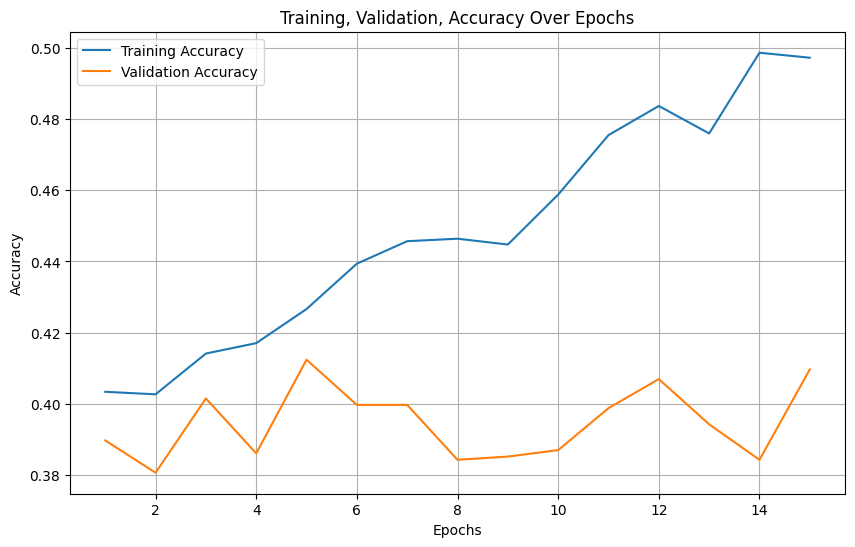

In [30]:
num_epochs = 100
patience = 10  # Set a patience for early stopping

# empty list of accuracy values for plotting
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0  # Keep track of the best validation accuracy
patience_counter = 0  # Counter for early stopping

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Calculate and append training accuracy to the list
    train_accuracy = calculate_accuracy(model, train_loader)  # Implement a function to calculate accuracy
    train_accuracies.append(train_accuracy)

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
    val_accuracy = calculate_accuracy(model, valid_loader)  # Implement a function to calculate accuracy
    val_accuracies.append(val_accuracy)


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0  # Reset patience counter if there is an improvement
        # Save the model if this is the best accuracy so far
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1  # Increment patience counter if no improvement

    # If patience counter reached the threshold, stop training
    if patience_counter >= patience:
        print("Early stopping triggered")
        break


# Plotting the accuracy curves
# Correct the epochs array to match the length of the accuracies
epochs = np.arange(1, len(train_accuracies) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Calculate and print validation accuracy
test_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

100%|██████████| 277/277 [00:00<00:00, 1719.56it/s]

Test Accuracy: 0.4072
Confusion Matrix:
[[395  47 135  31  25]
 [183  35 134   7  30]
 [117  16 245   7 125]
 [154  20  50  44  11]
 [ 41   8 167   2 181]]
